## Import Libraries

In [4]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim



## Load the Fashion MNIST dataset

100%|██████████| 26421880/26421880 [00:02<00:00, 11012553.57it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175643.16it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3259465.58it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7725322.72it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

First batch
torch.Size([100, 1, 28, 28])
tensor([9, 3, 4, 8, 8, 6, 8, 0, 5, 7, 2, 2, 2, 3, 1, 9, 9, 8, 9, 4, 7, 8, 9, 7,
        5, 9, 7, 1, 2, 9, 6, 6, 0, 2, 9, 5, 9, 3, 4, 5, 3, 2, 5, 8, 1, 9, 9, 5,
        7, 5, 4, 9, 5, 7, 0, 5, 6, 1, 1, 1, 6, 5, 3, 8, 1, 1, 9, 6, 3, 9, 7, 9,
        4, 3, 6, 5, 7, 4, 8, 5, 7, 7, 3, 2, 0, 5, 5, 5, 9, 1, 3, 9, 0, 9, 8, 1,
        3, 6, 4, 8])


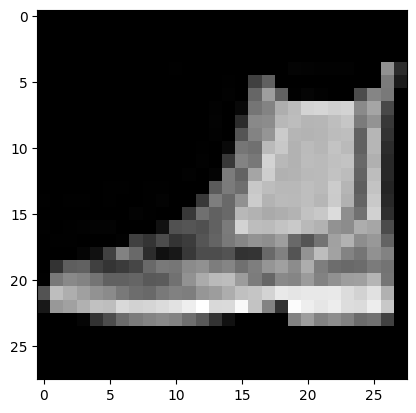

In [5]:
# Defining the transformations, normalizing the images to have values between -1 and 1
transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# Loading the Fashion MNIST dataset
fashion_mnist = FashionMNIST(root='./data',
                             train=True,
                             download=True,
                             transform=transform)

# Creating the DataLoader to load images in batches
batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size=batch_size, shuffle=True)

# Iterating through the DataLoader to get a batch of images
for img_batch, label_batch in data_loader:
    print('First batch')
    print(img_batch.shape)  # Shape of the image batch
    plt.imshow(img_batch[0][0], cmap='gray')  # Displaying the first image in the batch
    print(label_batch)  # Printing the labels of the batch
    break

## Define the discriminator network

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),  # Match this to (batch_size, 784)
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the image to (batch_size, 784)
        validity = self.model(img_flat)
        return validity


# Instantiation of the Discriminator
discriminator = Discriminator()
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## Define the Generator Network

In [15]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.model = nn.ModuleDict({
            'fc1': nn.Linear(input_dim, 256),
            'act1': nn.LeakyReLU(0.2),
            'bn1': nn.BatchNorm1d(256),
            'fc2': nn.Linear(256, 512),
            'act2': nn.LeakyReLU(0.2),
            'bn2': nn.BatchNorm1d(512),
            'fc3': nn.Linear(512, 1024),
            'act3': nn.LeakyReLU(0.2),
            'bn3': nn.BatchNorm1d(1024),
            'fc4': nn.Linear(1024, 784),
            'act4': nn.Tanh()
        })

    def forward(self, x):
        x = self.model['fc1'](x)
        x = self.model['act1'](x)
        x = self.model['bn1'](x)
        x = self.model['fc2'](x)
        x = self.model['act2'](x)
        x = self.model['bn2'](x)
        x = self.model['fc3'](x)
        x = self.model['act3'](x)
        x = self.model['bn3'](x)
        x = self.model['fc4'](x)
        x = self.model['act4'](x)
        return x

# Instantiation of the Generator
input_dim = 100  # Size of the input noise vector
G = Generator(input_dim=input_dim)
print(G)

Generator(
  (model): ModuleDict(
    (fc1): Linear(in_features=100, out_features=256, bias=True)
    (act1): LeakyReLU(negative_slope=0.2)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (act2): LeakyReLU(negative_slope=0.2)
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=512, out_features=1024, bias=True)
    (act3): LeakyReLU(negative_slope=0.2)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc4): Linear(in_features=1024, out_features=784, bias=True)
    (act4): Tanh()
  )
)


## Generating Samples from the GAN Model

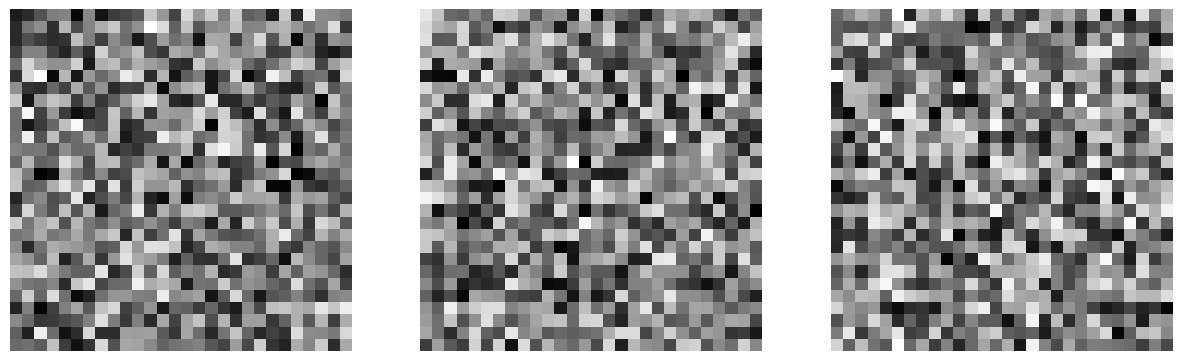

In [16]:
import os
latent_size = 100

# Denormalization function
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Directory to save generated images
os.makedirs("generated_samples", exist_ok=True)

# Generating random noise as input to the generator
num_samples = 3
y = G(torch.randn(num_samples, latent_size))

# Reshaping the generator output and apply denormalization
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())

# Plotting and Saving
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(gen_imgs[i], cmap='gray')
    ax.axis('off')  # Hiding axes ticks
    # Save each image
    plt.imsave(f"generated_samples/sample_{i+1}.png", gen_imgs[i].cpu().numpy(), cmap='gray')
plt.show()

#Some of the difficulties faced

1. Training Issues: Generating realistic images can take a significant number of epochs. If your GAN is not well trained, the output images may appear blurry, noisy, or incomprehensible.

2. Balancing Generator and Discriminator: If the discriminator becomes too strong, the generator may struggle to improve, leading to poor quality outputs.

3. Parameter Tuning: The learning rate, batch size, and other hyperparameters require fine-tuning to achieve stable training.

4. Visualizing Outputs: It's important to ensure proper denormalization of images. Improper scaling can lead to images that are not accurately visualized (e.g., too dark, too bright, or distorted).

## Discriminator Training

In [17]:
def train_discriminator(D, G, images, batch_size, latent_size, d_optimizer, criterion, device):
    # Creating the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Moving the images to the configured device
    images = images.to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combining losses
    d_loss = d_loss_real + d_loss_fake
    # Reset the gradients
    d_optimizer.zero_grad()
    # Computing the gradients
    d_loss.backward()
    # Adjusting the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

## Generator Training

In [18]:
def train_generator(G, D, batch_size, latent_size, g_optimizer, criterion, device):
    # Generating fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Resetting gradients
    g_optimizer.zero_grad()
    # Backpropagation
    g_loss.backward()
    # Updating generator's parameters
    g_optimizer.step()

    return g_loss, fake_images

## Training the GAN Model


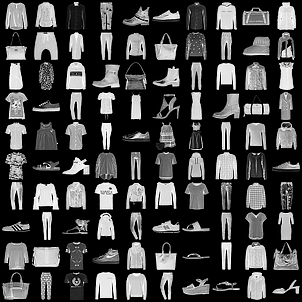

In [19]:
import os
from torchvision.utils import save_image

# Directory for saving samples
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Function to denormalize image
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Saving some real images from the dataset
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

# Displaying the saved image
from IPython.display import Image
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


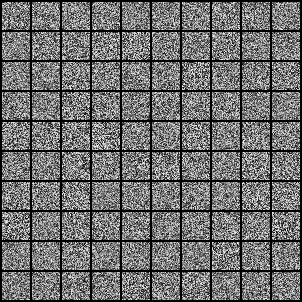

In [20]:
# Defining a helper function to save a batch of generated images to disk at the end of every epoch
import torch
from torchvision.utils import save_image
from IPython.display import Image
import os

# Ensuring the sample_dir is created
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Defining the function to save fake images
def save_fake_images(G, sample_vectors, index, sample_dir='samples', denorm=lambda x: x):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = f'fake_images-{index:04d}.png'
    print(f'Saving {fake_fname}')
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Generating a set of sample vectors (latent space vectors) for generating fake images
batch_size = 100
latent_size = 100
sample_vectors = torch.randn(batch_size, latent_size)  # Assuming CPU for simplicity

# Calling the function to save fake images before training starts
save_fake_images(G, sample_vectors, 0, sample_dir, denorm)

# Assuming 'sample_dir' is the directory where the images are saved
image_path = os.path.join(sample_dir, 'fake_images-0000.png')

# Displaying the image
Image(image_path)

## Training the model(first discriminator and then generator)

In [21]:
import torch
import time
from torchvision.utils import save_image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
latent_size = 100
batch_size = 100
num_epochs = 200

# Models
G = Generator(latent_size).to(device)
D = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)

# Loss function
criterion = nn.BCELoss()

start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)  # Adjusting for device

        # Training the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images, batch_size, latent_size, d_optimizer, criterion, device)

        # Generating noise for generator training
        z = torch.randn(batch_size, latent_size).to(device)

        # Training the generator
        g_loss, fake_images = train_generator(G, D, batch_size, latent_size, g_optimizer, criterion, device)

        if (i+1) % 200 == 0 or (i+1) == len(data_loader):
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Saving images at the end of each epoch
    save_fake_images(G=G, sample_vectors=sample_vectors.to(device), index=epoch + 1, sample_dir='samples', denorm=lambda x: (x + 1) / 2)

    # Saving the model checkpoints at specified epochs
    if epoch + 1 in [10, 50, 100, 150, 200]:
        torch.save(G.state_dict(), os.path.join(sample_dir, f'G_epoch_{epoch+1}.ckpt'))
        torch.save(D.state_dict(), os.path.join(sample_dir, f'D_epoch_{epoch+1}.ckpt'))
        print(f'Checkpoint saved for epoch {epoch+1}')

end_time = time.time()
print(f'Training complete in {end_time - start_time:.2f}s')

Epoch [1/200], Step [200/600], d_loss: 0.5231, g_loss: 3.3325, D(x): 0.96, D(G(z)): 0.24
Epoch [1/200], Step [400/600], d_loss: 0.0761, g_loss: 6.1978, D(x): 0.99, D(G(z)): 0.05
Epoch [1/200], Step [600/600], d_loss: 0.1001, g_loss: 7.9012, D(x): 0.94, D(G(z)): 0.01
Saving fake_images-0001.png
Epoch [2/200], Step [200/600], d_loss: 0.0890, g_loss: 8.4700, D(x): 0.97, D(G(z)): 0.03
Epoch [2/200], Step [400/600], d_loss: 0.0784, g_loss: 8.1230, D(x): 0.97, D(G(z)): 0.01
Epoch [2/200], Step [600/600], d_loss: 0.0236, g_loss: 9.8031, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [3/200], Step [200/600], d_loss: 0.0053, g_loss: 11.3171, D(x): 1.00, D(G(z)): 0.00
Epoch [3/200], Step [400/600], d_loss: 0.0078, g_loss: 11.0708, D(x): 1.00, D(G(z)): 0.01
Epoch [3/200], Step [600/600], d_loss: 0.0016, g_loss: 14.3797, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [4/200], Step [200/600], d_loss: 0.0141, g_loss: 12.5225, D(x): 0.99, D(G(z)): 0.00
Epoch [4/200], Step [4

## Saving model weights to be used later

In [22]:
# Saving the model weights in the folder to be used later
torch.save(G.state_dict(), 'generator_weights.pth')
torch.save(D.state_dict(), 'discriminator_weights.pth')

In [23]:
# Saving all the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [24]:
# Load the state dictionary
state_dict = torch.load('generator_weights.pth', map_location=device)

# Print the keys of the state dictionary
print(state_dict.keys())

odict_keys(['model.fc1.weight', 'model.fc1.bias', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.bn1.num_batches_tracked', 'model.fc2.weight', 'model.fc2.bias', 'model.bn2.weight', 'model.bn2.bias', 'model.bn2.running_mean', 'model.bn2.running_var', 'model.bn2.num_batches_tracked', 'model.fc3.weight', 'model.fc3.bias', 'model.bn3.weight', 'model.bn3.bias', 'model.bn3.running_mean', 'model.bn3.running_var', 'model.bn3.num_batches_tracked', 'model.fc4.weight', 'model.fc4.bias'])


<ipython-input-24-df589a89864a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('generator_weights.pth', map_location=device)


In [28]:
import torch
import torch.nn as nn

# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the Generator
G = Generator()

# Load the weights for the Generator
generator_weights = torch.load('generator_weights.pth', map_location=torch.device('cpu'))

# Rename the keys in the state_dict to match the Sequential model naming convention
new_generator_weights = {}
for key in generator_weights.keys():
    new_key = key.replace('fc1', '0').replace('bn1', '2').replace('fc2', '3').replace('bn2', '5') \
                  .replace('fc3', '6').replace('bn3', '8').replace('fc4', '9')
    new_generator_weights[new_key] = generator_weights[key]

# Load the renamed state_dict into the model
G.load_state_dict(new_generator_weights)

# Print message indicating successful loading of weights for the Generator
print("Generator weights loaded successfully.")


Generator weights loaded successfully.


<ipython-input-28-5ea973861232>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_weights = torch.load('generator_weights.pth', map_location=torch.device('cpu'))


In [29]:
import torch
import torch.nn as nn

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)  # Flattening the image
        return self.model(x)

# Instantiate the Discriminator
D = Discriminator()

# Load the weights for the Discriminator
discriminator_weights = torch.load('discriminator_weights.pth', map_location=torch.device('cpu'))
D.load_state_dict(discriminator_weights)

# Print message indicating successful loading of weights for the Discriminator
print("Discriminator weights loaded successfully.")

Discriminator weights loaded successfully.


<ipython-input-29-f8c7dd7ee993>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discriminator_weights = torch.load('discriminator_weights.pth', map_location=torch.device('

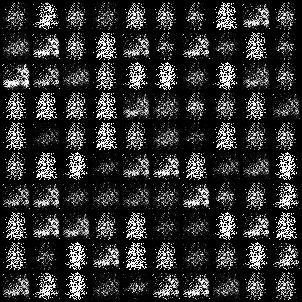

In [30]:
Image('./samples/fake_images-0010.png')

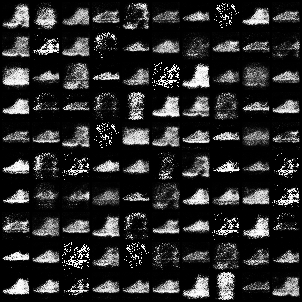

In [31]:
Image('./samples/fake_images-0050.png')

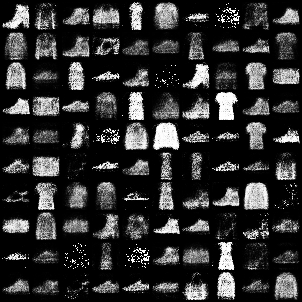

In [32]:
Image('./samples/fake_images-0100.png')

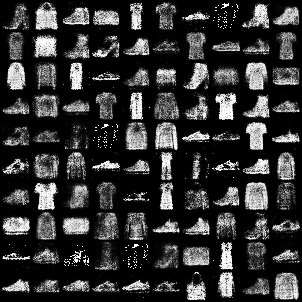

In [33]:
Image('./samples/fake_images-0150.png')

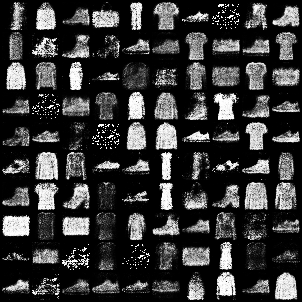

In [34]:
Image('./samples/fake_images-0200.png')

### Visualizing training process by combining the sample images generated after each epoch into a video using OpenCV.

In [35]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

#### Retraining the GAN Model with the saved weights

In [37]:
#### Retraining the GAN Model with the saved weights# Assuming device is set as follows
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the Generator and Discriminator to the device
G.to(device)
D.to(device)

# Initializing the lists to store losses and scores for plotting
g_losses = []
d_losses = []
real_scores = []
fake_scores = []

# Re-training the GAN model for 50 epochs
for epoch in range(50):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(device)

        # Train Discriminator
        d_optimizer.zero_grad()
        real_outputs = D(real_images)
        d_real_loss = criterion(real_outputs, torch.ones_like(real_outputs))

        z = torch.randn(batch_size, input_dim).to(device)
        fake_images = G(z)
        fake_outputs = D(fake_images.detach())
        d_fake_loss = criterion(fake_outputs, torch.zeros_like(fake_outputs))

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        fake_outputs = D(fake_images)
        g_loss = criterion(fake_outputs, torch.ones_like(fake_outputs))
        g_loss.backward()
        g_optimizer.step()

        # Saving the losses and scores for plotting
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        real_scores.append(torch.mean(real_outputs).item())
        fake_scores.append(torch.mean(fake_outputs).item())

        # Printing losses and scores
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{49}], Batch Step [{batch_idx}/{len(data_loader)}], "
                  f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}, "
                  f"Real Score: {torch.mean(real_outputs).item():.4f}, Fake Score: {torch.mean(fake_outputs).item():.4f}")

Epoch [0/49], Batch Step [0/600], Discriminator Loss: 1.1693, Generator Loss: 1.0579, Real Score: 0.6660, Fake Score: 0.4130
Epoch [0/49], Batch Step [100/600], Discriminator Loss: 1.2615, Generator Loss: 0.8935, Real Score: 0.6714, Fake Score: 0.4786
Epoch [0/49], Batch Step [200/600], Discriminator Loss: 0.9890, Generator Loss: 1.6741, Real Score: 0.6989, Fake Score: 0.3167
Epoch [0/49], Batch Step [300/600], Discriminator Loss: 1.0284, Generator Loss: 1.1056, Real Score: 0.6999, Fake Score: 0.3927
Epoch [0/49], Batch Step [400/600], Discriminator Loss: 0.9816, Generator Loss: 1.2389, Real Score: 0.6976, Fake Score: 0.3514
Epoch [0/49], Batch Step [500/600], Discriminator Loss: 1.1392, Generator Loss: 1.0338, Real Score: 0.6898, Fake Score: 0.4257
Epoch [1/49], Batch Step [0/600], Discriminator Loss: 1.1659, Generator Loss: 1.0987, Real Score: 0.6582, Fake Score: 0.3963
Epoch [1/49], Batch Step [100/600], Discriminator Loss: 0.8585, Generator Loss: 1.2911, Real Score: 0.7115, Fake Sc

#Visualizing the loses

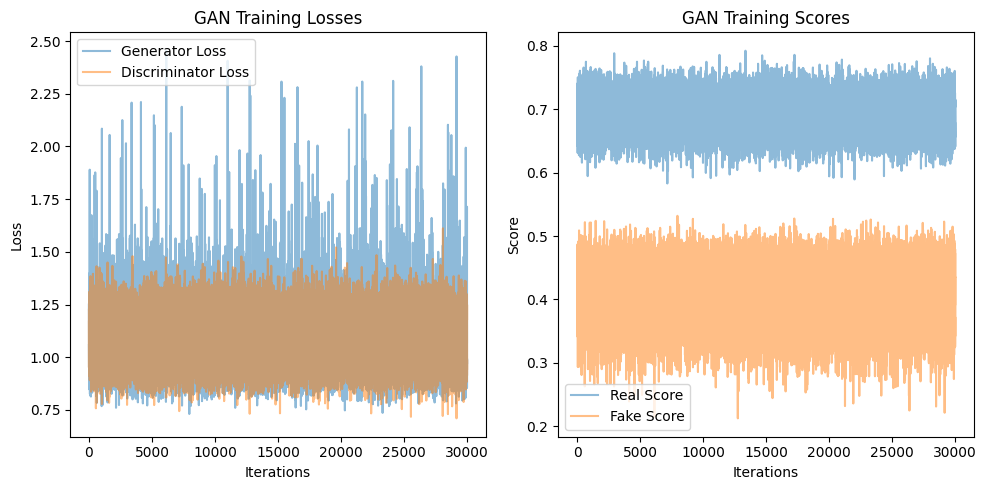

In [38]:
# Plotting the losses and scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(g_losses, label='Generator Loss', alpha=0.5)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.5)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(real_scores, label='Real Score', alpha=0.5)
plt.plot(fake_scores, label='Fake Score', alpha=0.5)
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('GAN Training Scores')
plt.legend()
plt.tight_layout()
plt.show()

The graphs show the progression of training losses and scores over iterations for a GAN (Generative Adversarial Network). The plot on the left visualizes the generator and discriminator losses. The generator loss fluctuates significantly, with high peaks suggesting instability or difficulty in optimizing the generator, while the discriminator loss remains relatively lower and more stable. Ideally, these losses should converge to a balance where the generator and discriminator learn effectively from each other. The right plot displays the real and fake scores, where the real score indicates how well the discriminator identifies real images, and the fake score indicates how well the discriminator distinguishes fake images generated by the generator. The relatively stable but fluctuating real and fake scores suggest that the discriminator maintains a consistent ability to classify real and fake images but does not achieve perfect classification, which is a sign of the generator making progress. However, the high variability in losses and scores indicates potential challenges in the training process, such as model instability or learning imbalances between the generator and discriminator. Fine-tuning hyperparameters or adjusting the architecture could help stabilize the training and improve performance.

In [39]:
# Save the model weights for both Generator and Discriminator
torch.save(G.state_dict(), 'generator_weights.pth')
torch.save(D.state_dict(), 'discriminator_weights.pth')
print("Saved the model weights without using checkpoints.")

Saved the model weights without using checkpoints.


In [40]:
# Instantiate the Generator and Discriminator models
G = Generator()
D = Discriminator()

# Load the saved weights for the Generator and Discriminator
G.load_state_dict(torch.load('generator_weights.pth', map_location=device))
D.load_state_dict(torch.load('discriminator_weights.pth', map_location=device))
print("Loaded the model weights without using checkpoints.")

Loaded the model weights without using checkpoints.


<ipython-input-40-03cba4f1b8a6>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('generator_weights.pth', map_location=device))
<ipython-input-4